# Part 2: Advanced Model Pipeline & Ensemble Methods

### Import Libraries

In [401]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

## 2.1 Data Preprocessing Pipeline

In [402]:
df = pd.read_csv("data/raw/TelcoCustomerChurnDataset.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Data Cleaning

In [403]:
# Convert TotalCharges to numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# data impute TotalCharges using Tenure * MonthlyCharges
mask = df["TotalCharges"].isna()
df.loc[mask, "TotalCharges"] = df.loc[mask, "tenure"] * df.loc[mask, "MonthlyCharges"]

### Feature Engineering

In [404]:
# Binning Tenure
def binning_tenure(score):
    if score < 10:
        return 'New'
    if score < 40:
        return 'Established'
    else:
        return 'Loyal'
    
df.insert(loc=6, column="TenureBins", value=df['tenure'].apply(binning_tenure))

In [405]:
def phone_service_type(row):
    if row["PhoneService"] == "No":
        return "No phone service"
    elif row["MultipleLines"] == "Yes":
        return "Multiple lines"
    else:
        return "Single line"

df.insert(loc=9, column="PhoneServiceType", value=df.apply(phone_service_type, axis=1))

In [406]:
internet_addons = [
    "OnlineSecurity", "OnlineBackup", "DeviceProtection",
    "TechSupport", "StreamingTV", "StreamingMovies"
]

def internet_service_add_ons(row):
    if row["InternetService"] == "No":
        return 0
    return sum(1 for col in internet_addons if row[col] == "Yes")

df.insert(loc=17, column="Service_Adoption_Score", value=df.apply(internet_service_add_ons, axis=1))

# Analyze
df[["PhoneServiceType", "InternetService", "OnlineSecurity", "OnlineBackup",
    "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies",
    "Service_Adoption_Score","MonthlyCharges"]].head()

,PhoneServiceType,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Service_Adoption_Score,MonthlyCharges
0,No phone service,DSL,No,Yes,No,No,No,No,1,29.85
1,Single line,DSL,Yes,No,Yes,No,No,No,2,56.95
2,Single line,DSL,Yes,Yes,No,No,No,No,2,53.85
3,No phone service,DSL,Yes,No,Yes,Yes,No,No,3,42.30
4,Single line,Fiber optic,No,No,No,No,No,No,0,70.70


### Feature Encoding

In [407]:
TenureBins_map = {"New": 0, "Established": 1, "Loyal": 2}
phone_service_type = {"No phone service": 0, "Single line": 1, "Multiple lines": 2}
internet_map = {"No": 0, "DSL": 1, "Fiber optic": 2}
contract_map = {"Month-to-month": 0, "One year": 1, "Two year": 2}

df["InternetService_encoded"] = df["InternetService"].map(internet_map)
df["Contract_encoded"] = df["Contract"].map(contract_map)
df["PhoneServiceType_encoded"] = df["PhoneServiceType"].map(phone_service_type)
df["TenureBins_encoded"] = df["TenureBins"].map(TenureBins_map)

# Check results
print(df[["InternetService", "InternetService_encoded",
          "Contract", "Contract_encoded",
          "PhoneServiceType", "PhoneServiceType_encoded",
          "TenureBins", "TenureBins_encoded"]].head(10))


  InternetService  InternetService_encoded        Contract  Contract_encoded  \
0             DSL                        1  Month-to-month                 0   
1             DSL                        1        One year                 1   
2             DSL                        1  Month-to-month                 0   
3             DSL                        1        One year                 1   
4     Fiber optic                        2  Month-to-month                 0   
5     Fiber optic                        2  Month-to-month                 0   
6     Fiber optic                        2  Month-to-month                 0   
7             DSL                        1  Month-to-month                 0   
8     Fiber optic                        2  Month-to-month                 0   
9             DSL                        1        One year                 1   

   PhoneServiceType  PhoneServiceType_encoded   TenureBins  TenureBins_encoded  
0  No phone service                   

In [408]:
# Binary encoding for Yes/No columns
binary_cols = ["Partner", "Dependents", "PaperlessBilling","Churn"]

for col in binary_cols:
    df[col + "_encoded"] = df[col].map({"Yes": 1, "No": 0})

In [409]:
# drop unnecessary coloumn
df = df.drop(
            columns=[
                        'customerID','gender','Partner','Dependents','PaperlessBilling',
                        'PhoneService','MultipleLines','tenure','OnlineSecurity','OnlineBackup',
                        'DeviceProtection','TechSupport','StreamingTV','StreamingMovies'
                        ,'InternetService','Contract','PhoneServiceType','TenureBins', 'Churn'
                    ]
            )

df.head(10)

,SeniorCitizen,Service_Adoption_Score,PaymentMethod,MonthlyCharges,TotalCharges,InternetService_encoded,Contract_encoded,PhoneServiceType_encoded,TenureBins_encoded,Partner_encoded,Dependents_encoded,PaperlessBilling_encoded,Churn_encoded
0,0,1,Electronic check,29.85,29.85,1,0,0,0,1,0,1,0
1,0,2,Mailed check,56.95,1889.50,1,1,1,1,0,0,0,0
2,0,2,Mailed check,53.85,108.15,1,0,1,0,0,0,1,1
3,0,3,Bank transfer (automatic),42.30,1840.75,1,1,0,2,0,0,0,0
4,0,0,Electronic check,70.70,151.65,2,0,1,0,0,0,1,1
5,0,3,Electronic check,99.65,820.50,2,0,2,0,0,0,1,1
6,0,2,Credit card (automatic),89.10,1949.40,2,0,2,1,0,1,1,0
7,0,1,Mailed check,29.75,301.90,1,0,0,1,0,0,0,0
8,0,4,Electronic check,104.80,3046.05,2,0,2,1,1,0,1,1
9,0,2,Bank transfer (automatic),56.15,3487.95,1,1,1,2,0,1,0,0


### Feature Scaling

In [410]:
numerical_features = ['MonthlyCharges', 'TotalCharges']
nominal_features = [ 'PaymentMethod' ]
remainder_features = ['SeniorCitizen', 'Partner_encoded', 'Dependents_encoded',
                     'PaperlessBilling_encoded', 'Service_Adoption_Score','TenureBins_encoded',
                     'PhoneServiceType_encoded', 'InternetService_encoded', 'Contract_encoded', 'Churn_encoded']

numerical_transformer = Pipeline(
                                steps=[
                                    ('scaler', StandardScaler())
                                ]
                                )

nominal_transformer = Pipeline(
                                steps=[
                                    ('encoder', OneHotEncoder())
                                ]
                                )
 
preprocessor = ColumnTransformer(
                                transformers=[
                                    ('num', numerical_transformer, numerical_features),
                                    ('nom', nominal_transformer, nominal_features)
                                ],
                                remainder='drop'
                                )

nominal_feature_names = []
for feature in nominal_features:
    unique_values = df[feature].unique()
    nominal_feature_names.extend([f"{feature}_{val}" for val in unique_values])
  
df_cp = df.copy()
df_transformed = pd.DataFrame(
    preprocessor.fit_transform(df_cp),
    columns= numerical_features + nominal_feature_names
)

df_transformed

df_remainder = df[remainder_features]
df_pp = pd.concat([df_transformed, df_remainder], axis=1)

df_pp.head(10)

,MonthlyCharges,TotalCharges,PaymentMethod_Electronic check,PaymentMethod_Mailed check,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),SeniorCitizen,Partner_encoded,Dependents_encoded,PaperlessBilling_encoded,Service_Adoption_Score,TenureBins_encoded,PhoneServiceType_encoded,InternetService_encoded,Contract_encoded,Churn_encoded
0,-1.160323,-0.992611,0.0,0.0,1.0,0.0,0,1,0,1,1,0,0,1,0,0
1,-0.259629,-0.172165,0.0,0.0,0.0,1.0,0,0,0,0,2,1,1,1,1,0
2,-0.362660,-0.958066,0.0,0.0,0.0,1.0,0,0,0,1,2,0,1,1,0,1
3,-0.746535,-0.193672,1.0,0.0,0.0,0.0,0,0,0,0,3,2,0,1,1,0
4,0.197365,-0.938874,0.0,0.0,1.0,0.0,0,0,0,1,0,0,1,2,0,1
5,1.159546,-0.643789,0.0,0.0,1.0,0.0,0,0,0,1,3,0,2,2,0,1
6,0.808907,-0.145738,0.0,1.0,0.0,0.0,0,0,1,1,2,1,2,2,0,0
7,-1.163647,-0.872587,0.0,0.0,0.0,1.0,0,0,0,0,1,1,0,1,0,0
8,1.330711,0.338085,0.0,0.0,1.0,0.0,0,1,0,1,4,1,2,2,0,1
9,-0.286218,0.533044,1.0,0.0,0.0,0.0,0,0,1,0,2,2,1,1,1,0


#### Save Preprocessed dataset

In [411]:
df_pp.to_csv('data/processed/PreProcessed.csv', index=False)

### Train Test Split

In [412]:
X = df_pp.drop(columns=['Churn_encoded'])
Y = df_pp['Churn_encoded']

In [413]:
X_train, X_test, Y_train, Y_test = train_test_split(
                                                    X, Y, 
                                                    test_size=0.2, 
                                                    random_state=42
                                                    )

## 2.2 Ensemble Model Implementation

### 2.2.1 Bagging Method: Random Forest 

In [414]:
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "max_features": ["sqrt", "log2"]
}

rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf, param_grid, cv=3, scoring="accuracy", n_jobs=-1, verbose=2)
grid_rf.fit(X_train, Y_train)

# Best model
best_rf = grid_rf.best_estimator_

Y_pred_rf = best_rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(Y_test, Y_pred_rf))


Fitting 3 folds for each of 72 candidates, totalling 216 fits
Random Forest Accuracy: 0.8090844570617459


### 2.2.2 Boosting Method: XGBoost

In [415]:
xgb_clf = xgb.XGBClassifier(eval_metric="logloss", random_state=42)

param_grid = {
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "n_estimators": [100, 200, 300],
    "subsample": [0.7, 0.8, 1.0]
}

grid_xgb = GridSearchCV(xgb_clf, param_grid, cv=3, scoring="accuracy", n_jobs=-1, verbose=2)
grid_xgb.fit(X_train, Y_train)

best_xgb = grid_xgb.best_estimator_
Y_pred_xgb = best_xgb.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(Y_test, Y_pred_xgb))


Fitting 3 folds for each of 81 candidates, totalling 243 fits
XGBoost Accuracy: 0.8097941802696949


### 2.2.3 Advanced Boosting: CatBoost

In [416]:
cat_clf = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    eval_metric="Accuracy",
    random_seed=42,
    verbose=100
)

cat_clf.fit(X_train, Y_train, eval_set=(X_test,Y_test))

Y_pred_cat = cat_clf.predict(X_test)

print("CatBoost Accuracy:", accuracy_score(Y_test, Y_pred_cat))


0:	learn: 0.7804402	test: 0.7870830	best: 0.7870830 (0)	total: 3.62ms	remaining: 1.8s
100:	learn: 0.8285410	test: 0.8119233	best: 0.8154720 (33)	total: 260ms	remaining: 1.03s
200:	learn: 0.8585375	test: 0.8105039	best: 0.8168914 (109)	total: 524ms	remaining: 780ms
300:	learn: 0.8787717	test: 0.8012775	best: 0.8168914 (109)	total: 787ms	remaining: 520ms
400:	learn: 0.8961661	test: 0.8034067	best: 0.8168914 (109)	total: 1.05s	remaining: 260ms
499:	learn: 0.9121406	test: 0.7991483	best: 0.8168914 (109)	total: 1.32s	remaining: 0us

bestTest = 0.8168914123
bestIteration = 109

Shrink model to first 110 iterations.
CatBoost Accuracy: 0.8168914123491838


### 2.2.4 Baseline Comparison 

#### Logistic Regression

In [417]:
log_reg = LogisticRegression(max_iter=1000, solver='lbfgs')
log_reg.fit(X_train, Y_train)

Y_pred_log = log_reg.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(Y_test, Y_pred_log))

Logistic Regression Accuracy: 0.8119233498935415


#### Decision Tree

In [418]:
dt_clf = DecisionTreeClassifier(max_depth=4, random_state=42)
dt_clf.fit(X_train, Y_train)

Y_pred_dt = dt_clf.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(Y_test, Y_pred_dt))

Decision Tree Accuracy: 0.7927608232789212


In [419]:
results = {
    "Random Forest": accuracy_score(Y_test, Y_pred_rf),
    "XGBoost": accuracy_score(Y_test, Y_pred_xgb),
    "CatBoost": accuracy_score(Y_test, Y_pred_cat),
    "Logistic Regression": accuracy_score(Y_test, Y_pred_log),
    "Decision Tree": accuracy_score(Y_test, Y_pred_dt)
}

print("Model Comparison:", results)


Model Comparison: {'Random Forest': 0.8090844570617459, 'XGBoost': 0.8097941802696949, 'CatBoost': 0.8168914123491838, 'Logistic Regression': 0.8119233498935415, 'Decision Tree': 0.7927608232789212}


# Part 3: Model Evaluation for Imbalanced Data

### 3.2 Comprehensive Evaluation Metrics

#### 3.2.1 Primary Metrics

In [420]:
models = [
    ("Random Forest", Y_pred_rf),
    ("XGBoost", Y_pred_xgb),
    ("CatBoost", Y_pred_cat),
    ("Logistic Regression", Y_pred_log),
    ("Decision Tree", Y_pred_dt)
]

for model_name, y_pred in models:
    print(f"\n{model_name} Classification Report:")
    print("=" * 50)
    print(classification_report(Y_test, y_pred))
    print("=" * 50)


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.88      1036
           1       0.68      0.52      0.59       373

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.88      1036
           1       0.68      0.54      0.60       373

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.74      1409
weighted avg       0.80      0.81      0.80      1409


CatBoost Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1036
           1       0.69      0.55      0.61       373

    accuracy                           0.82      1409
   macro avg       0.77  

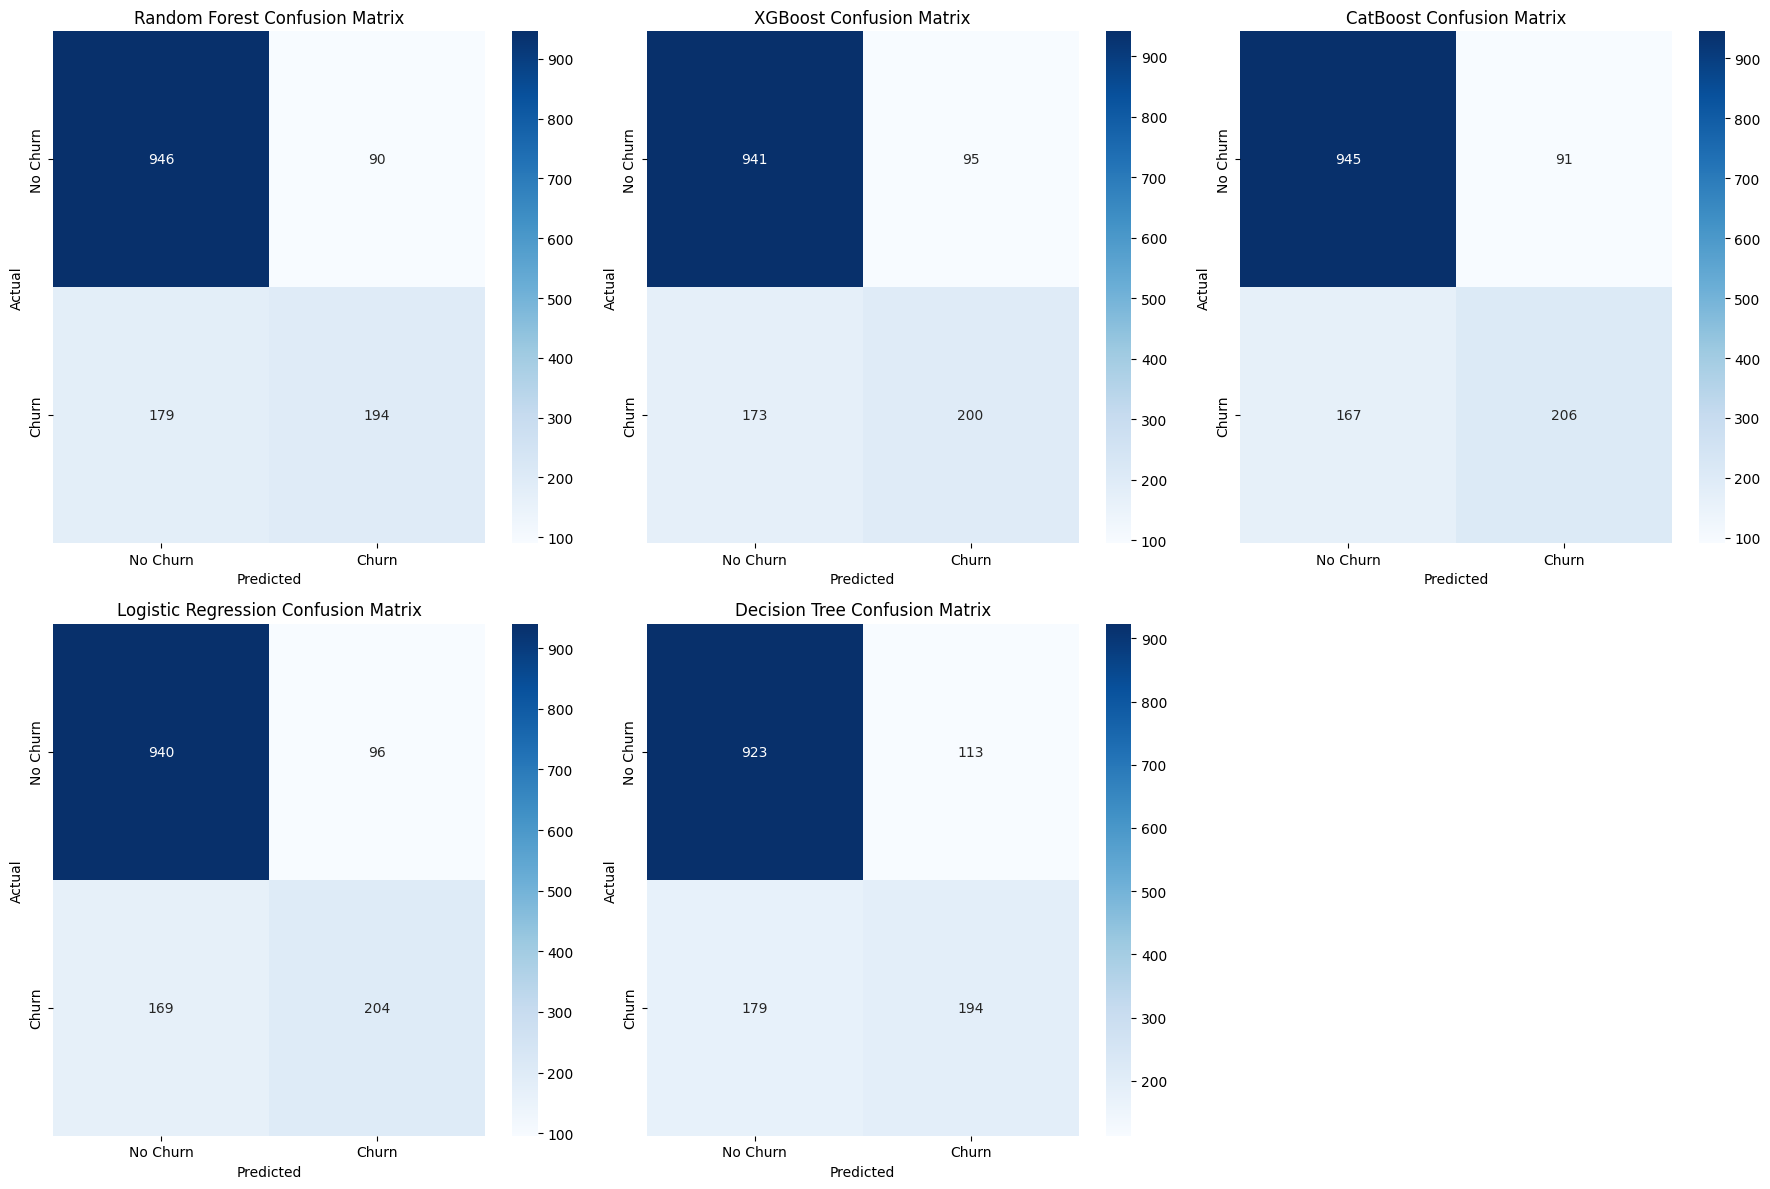

In [421]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

models = [
    ("Random Forest", Y_pred_rf),
    ("XGBoost", Y_pred_xgb),
    ("CatBoost", Y_pred_cat),
    ("Logistic Regression", Y_pred_log),
    ("Decision Tree", Y_pred_dt)
]

for i, (model_name, y_pred) in enumerate(models):
    cm = confusion_matrix(Y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=["No Churn", "Churn"], 
                yticklabels=["No Churn", "Churn"],
                ax=axes[i])
    axes[i].set_title(f"{model_name} Confusion Matrix")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

# Hide the empty subplot
if len(models) < 6:
    axes[5].set_visible(False)

plt.tight_layout()
plt.show()